# Classes Report Multiclass

The aim of this notebook is using pattern mining in order to exploit frequent terms and associations to user whenever a twitter were classified as cyberbullying.

## Library Import

In [5]:
import pandas as pd
import joblib
from mlxtend.frequent_patterns import apriori
import matplotlib.pyplot as plt
from itertools import combinations
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.text_preprocessing import preprocess_text, TextPreprocessor #run time usage
from utils.bad_word_blurrer import blur_text
from utils.frequent_pattern import get_itemsets

## Dataset Vectorization and PatternMining Preparation

In [6]:
df = pd.read_csv("../dataset/training_set.csv")
df["text"] = df["text"].apply(preprocess_text)
df = df[df['multiclass_label'] != 'not_cyberbullying'].copy()

pipeline = joblib.load("../model/multiclass/RandomForest_TF-IDF_multiclass.pkl")
vectorizer = pipeline.named_steps["vectorizer"]

X_tfidf = vectorizer.transform(df['text'])
X_tfidf = (X_tfidf > 0).astype(int)

tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df["multiclass_label"] = df["multiclass_label"].values



## Frequent terms & associations mining

/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_3401/1229291999.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_support.values, y=blurred_index, palette="viridis")


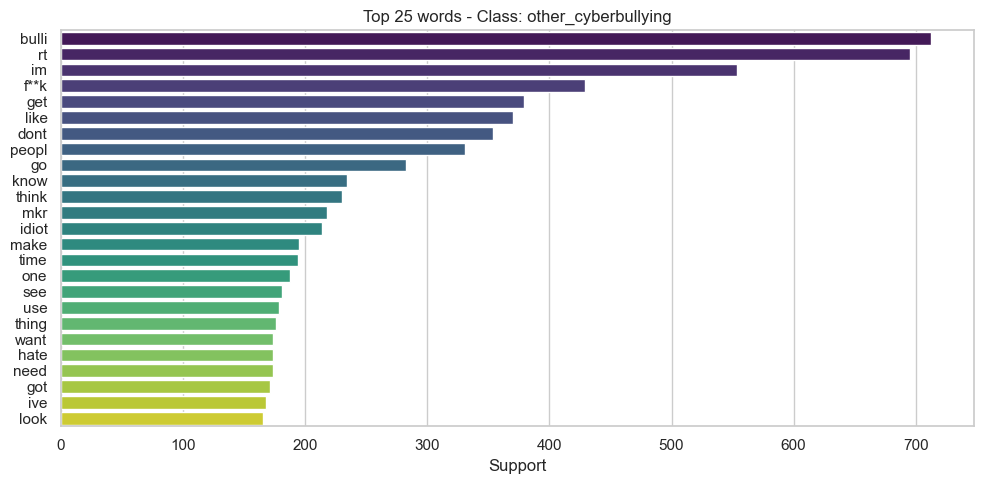

/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_3401/1229291999.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_support.values, y=blurred_index, palette="viridis")


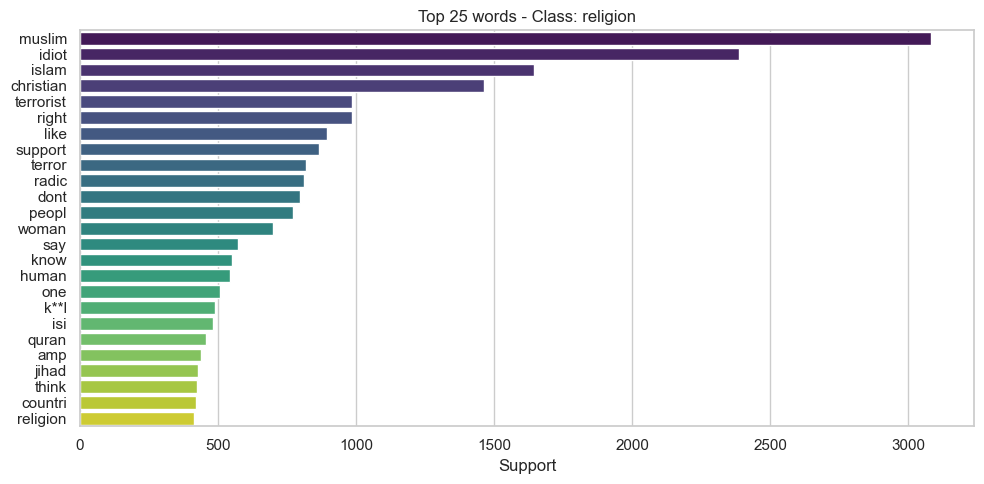

/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_3401/1229291999.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_support.values, y=blurred_index, palette="viridis")


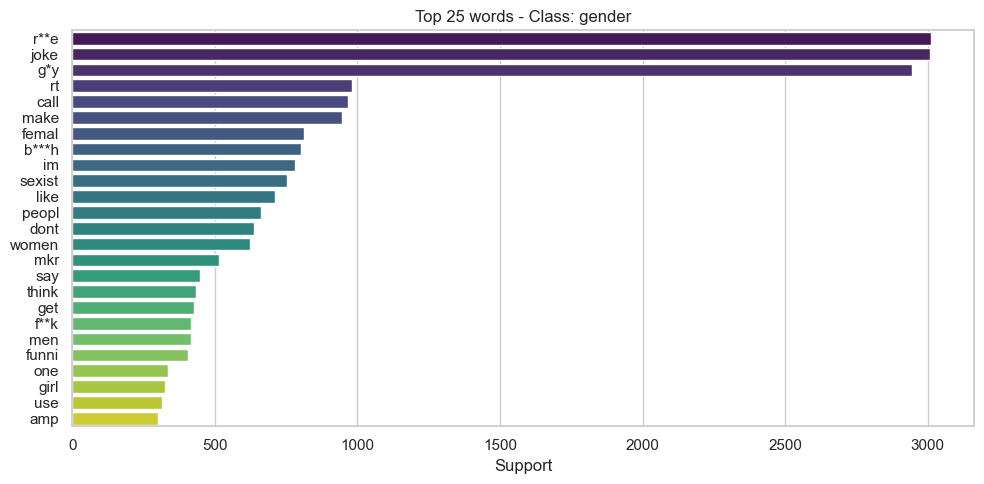

/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_3401/1229291999.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_support.values, y=blurred_index, palette="viridis")


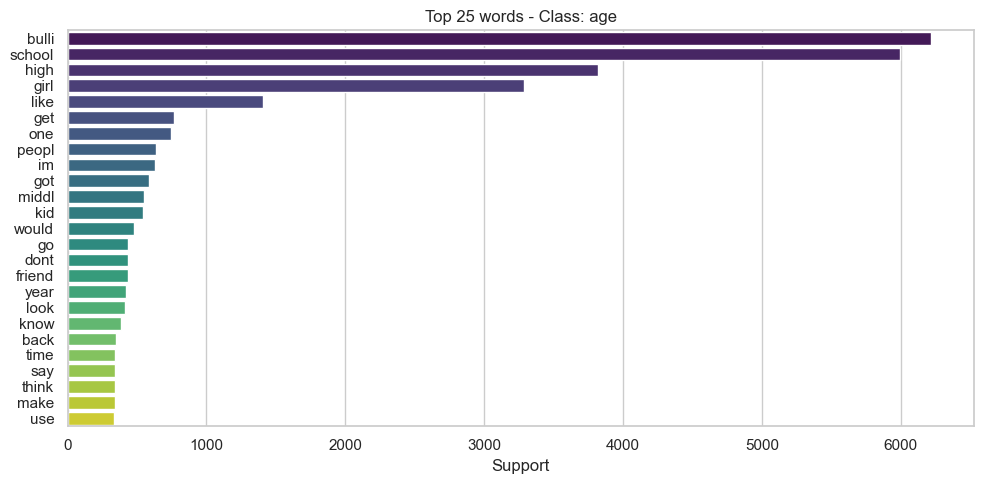

/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_3401/1229291999.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_support.values, y=blurred_index, palette="viridis")


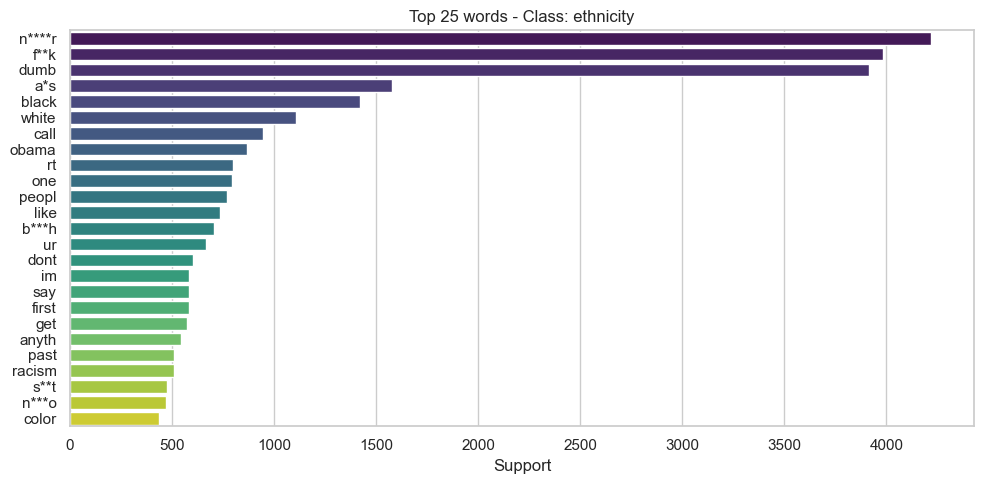

/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [7]:

classes = tfidf_df['multiclass_label'].unique()
closed_by_class = {}
maximal_by_class = {}

sns.set(style="whitegrid")

for cla in classes:
    class_df = tfidf_df[tfidf_df['multiclass_label'] == cla].drop(columns=['multiclass_label'])

    word_support = class_df.sum().sort_values(ascending=False).head(25)
    blurred_index = [blur_text(word) for word in word_support.index]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=word_support.values, y=blurred_index, palette="viridis")
    plt.title(f"Top 25 words - Class: {cla}")
    plt.xlabel("Support")
    plt.tight_layout()

    safe_class = cla.replace("/", "-")
    filename = f"../word_class_distribution/top_25_{safe_class}.png"
    plt.savefig(filename)
    plt.show()

    frequent_itemsets = apriori(class_df, min_support=0.05, use_colnames=True)
    closed_sets = get_itemsets(frequent_itemsets,'closed')
    maximal_sets = get_itemsets(frequent_itemsets,'maximal')

    closed_by_class[cla] = closed_sets
    maximal_by_class[cla] = maximal_sets


## Rules Formatting for Interpretability

In [8]:
# CLOSED
closed_rows = []
for cla, df in closed_by_class.items():
    for _, row in df.iterrows():
        closed_rows.append({
            'class': cla,
            'itemset': ', '.join(row['itemsets']),
            'support': row['support']
        })

closed_df = pd.DataFrame(closed_rows)
closed_df.to_csv("../itemset/closed_itemsets_by_class_multiclass.csv", index=False)

# MAXIMAL
maximal_rows = []
for cla, df in maximal_by_class.items():
    for _, row in df.iterrows():
        maximal_rows.append({
            'class': cla,
            'itemset': ', '.join(row['itemsets']),
            'support': row['support']
        })

maximal_df = pd.DataFrame(maximal_rows)
maximal_df.to_csv("../itemset/maximal_itemsets_by_class_multiclass.csv", index=False)

print("Distribution CLOSED itemsets:")
print(closed_df['class'].value_counts())
print("\nDistribution MAXIMAL itemsets:")
print(maximal_df['class'].value_counts())


Distribution CLOSED itemsets:
class
age                    147
ethnicity              131
religion                63
gender                  62
other_cyberbullying      8
Name: count, dtype: int64

Distribution MAXIMAL itemsets:
class
religion               30
age                    25
ethnicity              25
gender                 20
other_cyberbullying     8
Name: count, dtype: int64
